#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [ ]:
# Testing if integration works

In [9]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [10]:
#file_name = 'multicoil_train/file1000167.h5'
file_name = "../data/multicoil/file1000162_v2.h5"
hf = h5py.File(file_name)

In [11]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'CORPDFS_FBK', 'num_low_frequency': 30, 'patient_id': '3e443348ba242fd8a6e4c14a9990f72eaeadea9f146b782d559733e04b303d44'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [12]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(35, 15, 640, 372)


In [13]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [14]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

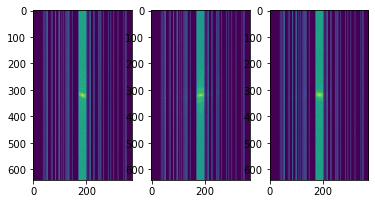

In [15]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [16]:
import fastmri
from fastmri.data import transforms as T

In [17]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

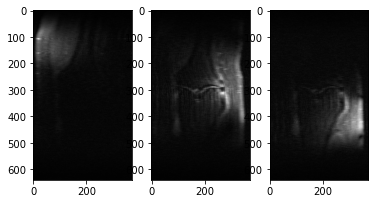

In [18]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [19]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

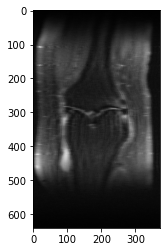

In [20]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [21]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [22]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [23]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

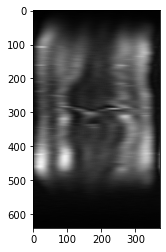

In [24]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

Single-Coil Data Understanding

In [25]:
file_name = "../data/singlecoil_val/file1000000.h5"
hf = h5py.File(file_name)

In [26]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00017707173297391214, 'norm': 0.058663394182755665, 'patient_id': 'b2a82c7521fe2d4aebb627bbaae92a1916bf06e75cb374fc4187b0909e5c0e36'}


In [27]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(35, 640, 368)


In [29]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

In [35]:
def show_single_coil(data, cmap=None):
    fig = plt.figure()
    plt.imshow(data, cmap=cmap)

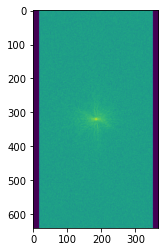

In [36]:
show_single_coil(np.log(np.abs(slice_kspace) + 1e-9))  # This shows coils 0, 5 and 10

In [ ]:
# Need to compute IFFT and get abs to see the real image

In [37]:
import fastmri
from fastmri.data import transforms as T

In [38]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

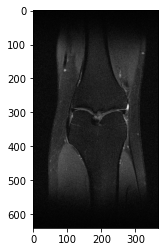

In [41]:
show_single_coil(slice_image_abs, cmap="gray")  # This shows coils 0, 5 and 10

Evaluate Pretrained Model Results

In [46]:
dir(fastmri)

['SSIMLoss',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'coil_combine',
 'complex_abs',
 'complex_abs_sq',
 'complex_conj',
 'complex_mul',
 'convert_fnames_to_v2',
 'data',
 'fft2c',
 'fftc',
 'fftshift',
 'ifft2c',
 'ifftshift',
 'losses',
 'math',
 'roll',
 'rss',
 'rss_complex',
 'save_reconstructions',
 'tensor_to_complex_np',
 'torch',
 'utils',
 'version']